In [414]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from scipy import ndimage
from skimage.feature import peak_local_max
from sklearn.cluster import DBSCAN, AffinityPropagation, MeanShift
from matplotlib import cm

In [2]:
MIN = 0
MAX = 2 ** 16 - 1

In [3]:
PATH = '../sequences/0'
imgs = []
for i in range(1, 5):
    imgs_path = []
    for image in glob(f'{PATH}{i}/*.tif'):
        img = cv2.imread(image, -1)
        imgs_path.append(cv2.normalize(img, dst=None, alpha=MIN, beta=MAX, norm_type=cv2.NORM_MINMAX))
    imgs.append(imgs_path)

In [4]:
NROWS = imgs[0][0].shape[0]
NCOLS = imgs[0][0].shape[1]

In [5]:
def show(img, s=True):
    plt.imshow(img, cmap='gray')
    if s:
        plt.show()

## SEGMENTATION

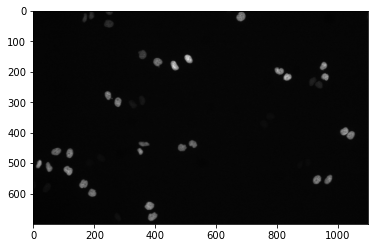

In [6]:
show(imgs[0][0])

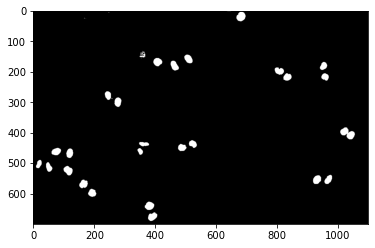

In [7]:
img = np.zeros_like(imgs[0][0])
cv2.threshold(imgs[0][0], dst=img, thresh=None, maxval=MAX, type=cv2.THRESH_OTSU)
show(img)

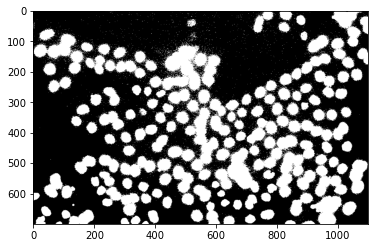

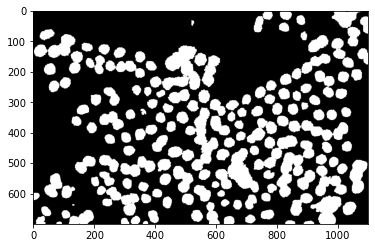

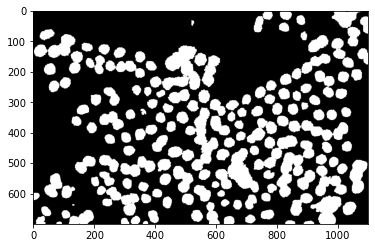

In [8]:
img = np.zeros_like(imgs[3][0])
cv2.threshold(imgs[3][-1], dst=img, thresh=np.median(imgs[3][-1])*1.2, maxval=MAX, type=cv2.THRESH_BINARY)
show(img)
struct_element = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=(5,5))
img1 = np.zeros_like(imgs[3][0])
cv2.morphologyEx(img, dst=img1, op=cv2.MORPH_OPEN, kernel=struct_element, borderValue=cv2.BORDER_REFLECT)
show(img1)
img2 = np.zeros_like(imgs[3][0])
cv2.threshold(img1, dst=img2, thresh=MAX-1, maxval=MAX, type=cv2.THRESH_BINARY)
show(img2)

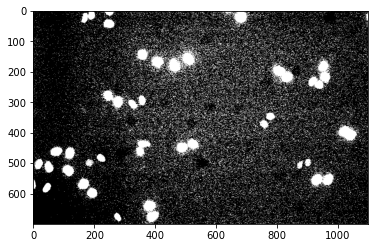

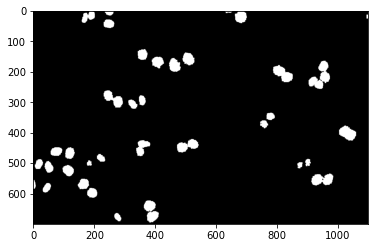

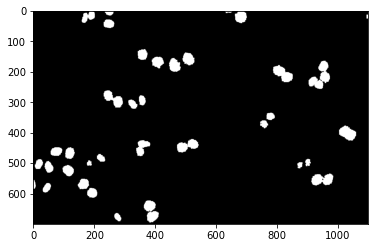

In [9]:
img = np.zeros_like(imgs[0][0])
cv2.threshold(imgs[0][0], dst=img, thresh=np.median(imgs[0][0])*1.2, maxval=MAX, type=cv2.THRESH_BINARY)
show(img)
struct_element = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=(5,5))
img1 = np.zeros_like(imgs[0][0])
cv2.morphologyEx(img, dst=img1, op=cv2.MORPH_OPEN, kernel=struct_element, borderValue=cv2.BORDER_REFLECT)
show(img1)
img3 = np.zeros_like(imgs[0][0])
cv2.threshold(img1, dst=img3, thresh=MAX-1, maxval=MAX, type=cv2.THRESH_BINARY)
show(img3)

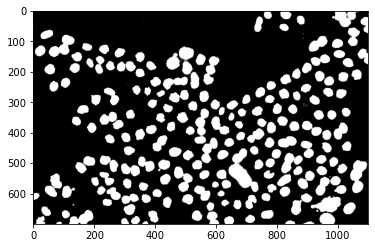

In [379]:
img = np.zeros_like(imgs[0][0])
cv2.threshold(imgs[3][-1], dst=img, thresh=2400, maxval=MAX, type=cv2.THRESH_BINARY)
show(img)

sometimes the cells are included only in low(ish) thresholds

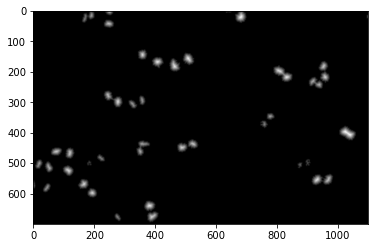

In [11]:
dt = ndimage.distance_transform_edt(img3)
show(dt)

In [12]:
coords = peak_local_max(dt, min_distance=4, labels=img3)
coords.shape

(57, 2)

In [392]:
def segment(original):
    img = np.zeros(original)
    cv2.threshold(original, dst=img, thresh=np.median(original)*1.2, maxval=MAX, type=cv2.THRESH_BINARY)
    struct_element = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=(5,5))
    img1 = np.zeros_like(original)
    cv2.morphologyEx(img, dst=img1, op=cv2.MORPH_OPEN, kernel=struct_element, borderValue=cv2.BORDER_REFLECT)
    img2 = np.zeros_like(original)
    cv2.threshold(img1, dst=img2, thresh=MAX-1, maxval=MAX, type=cv2.THRESH_BINARY)
    return img2

In [13]:
def points(img):
    pts = {}
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i,j] == MAX:
                pts[(i,j)] = None
    return pts

## EROSION: to find centroids

In [14]:
pts1 = points(img3)

In [15]:
def is_last(pt, pts):
    for i in range(-1,2):
        for j in range(-1,2):
            if i == j and i == 0:
                continue
            if (pt[0]+i, pt[1]+j) in pts:
                return False
    return True

In [16]:
def eroded(pts):
    new1 = pts.copy()
    for pt in pts.keys():
        if (pt[0], pt[1]-1) in pts and (pt[0], pt[1]+1) in pts:
            continue
        elif is_last(pt, new1) and num_connected(pt, pts, new1, {}) == 1:
        #elif num_connected(pt, pts, new1, {}) == 1:
            new1[pt] = None
        else:
            del new1[pt]
    new2 = new1.copy()
    for pt in new1.keys():
        if (pt[0]-1, pt[1]) in new1 and (pt[0]+1, pt[1]) in new1:
            continue
        elif is_last(pt, new2) and num_connected(pt, new1, new2, {}) == 1:
        #elif num_connected(pt, new1, new2, {}) == 1:
            new2[pt] = None
        else:
            del new2[pt]
    '''
    new1 = {}
    # pass with S = 1x3 filter
    for pt in pts.keys():
        if (pt[0], pt[1]-1) in pts and (pt[0], pt[1]+1) in pts:
            new1[pt] = None
        elif is_last(pt, new1):
            new1[pt] = None
        #elif (pt[0], pt[1]-1) not in pts and (pt[0], pt[1]+1) not in pts and is_last(pt, pts):
            #new1[pt] = None
    new2 = {}
    # pass with S = 3x1 filter
    for pt in new1.keys():
        if (pt[0]-1, pt[1]) in new1 and (pt[0]+1, pt[1]) in new1:
            new2[pt] = None
        elif is_last(pt, new2):
            new2[pt] = None
        #elif (pt[0]-1, pt[1]) not in new1 and (pt[0]+1, pt[1]) not in new1 and is_last(pt, new1):
            #new2[pt] = None
    '''
    return new2

In [17]:
pts2 = eroded(pts1)

In [18]:
len(pts1)

35462

In [19]:
len(pts2)

29898

In [20]:
def create_img(pts):
    new = np.zeros((NROWS, NCOLS))
    for (i, j) in pts:
        new[i, j] = MAX
    return new


In [21]:
imgz = create_img(pts2)

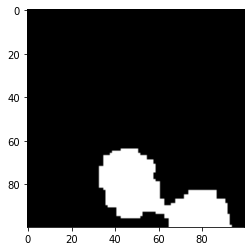

In [22]:
show(imgz[200:300,200:300])

In [23]:
# BFS search of connected components, count number in new points dict
def num_connected(pt, old_pts, new_pts, already):
    already[(pt[0],pt[1])] = None
    count = 0
    #print(pt)
    #print(already)
    for i in range(-1, 2):
        for j in range(-1, 2):
            if (pt[0]+i,pt[1]+j) not in old_pts or (pt[0]+i,pt[1]+j) in already:
                continue
            already[(pt[0],pt[1])] = None
            count += num_connected((pt[0]+i,pt[1]+j), old_pts, new_pts, already)
    if (pt[0], pt[1]) in new_pts:
        count += 1
    return count
       

In [24]:
def centroids(img):
    pts = points(img)
    num = 0
    while 1:
        num += 1
        pts_before = pts.copy()
        pts = eroded(pts)
        show(create_img(pts)[0:50,100:200])
        #show(create_img(pts))
        if pts == pts_before:
            print(num)
            return pts

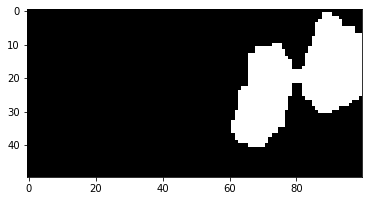

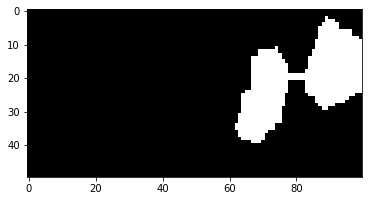

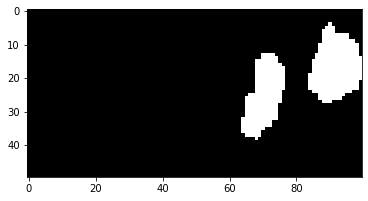

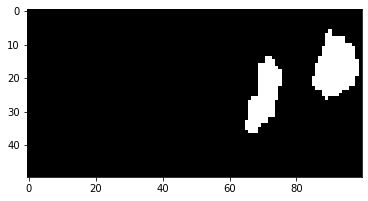

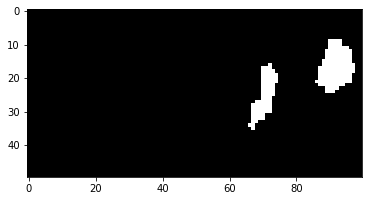

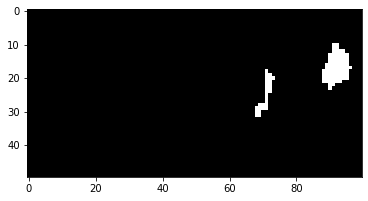

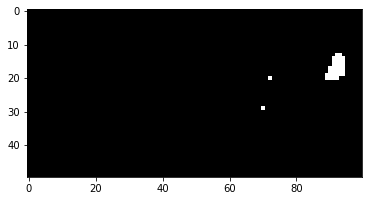

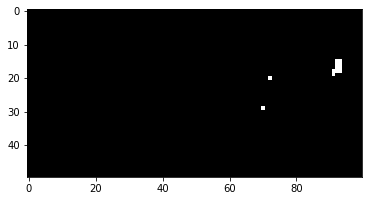

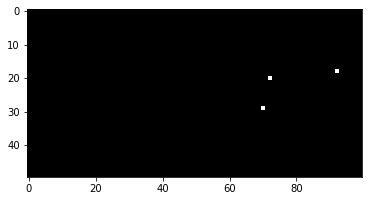

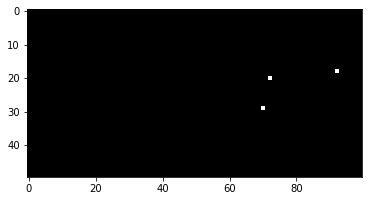

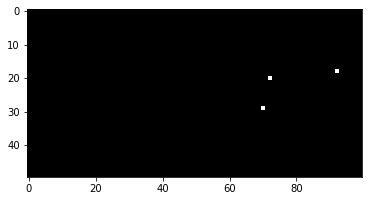

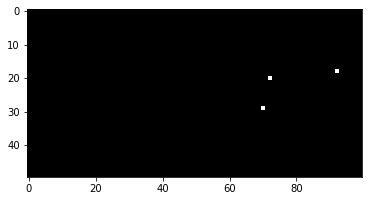

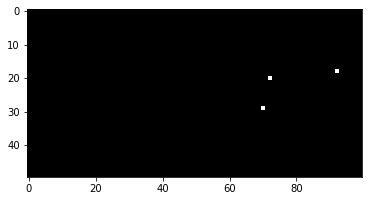

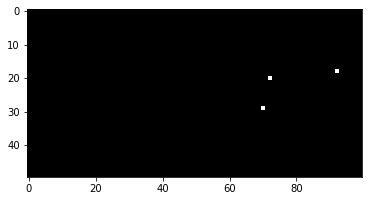

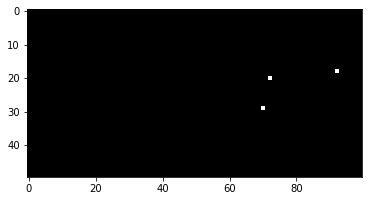

15


In [25]:
pts_final = centroids(img3)

In [26]:
len(pts_final)

70

#### shows promise if cells are not joined, try later with suboptimal threshold that gives all regularly unjoined cells in img as unjoined in thresholded if possible, try points with kMeansClustering

## Erase Border Cells

In [27]:
def DFS(pt, pts, connect):
    connect[pt] = None
    x, y = pt
    for i in range(-1, 2):
        for j in range(-1, 2):
            if (x+i,j+y) in pts and (x+i,j+y) not in connect:
                DFS((x+i,j+y), pts, connect)
    return connect

In [28]:
# DO NOT USE: recursion depth can be exceeded easily and brick python interpreter
def flush_border(pts):
    new = pts.copy()
    delete = {}
    for pt in pts:
        edge = pt[1] == 0 or pt[1] == NCOLS-1 or pt[0] == 0 or pt[0] == NROWS-1
        if edge and pt not in delete:
            connect = DFS(pt, pts, {})
            for pt in connect:
                delete[pt] = None
    for pt in delete.keys():
        del new[pt]
    return new

In [29]:
pts = points(img3)
new = flush_border(pts)

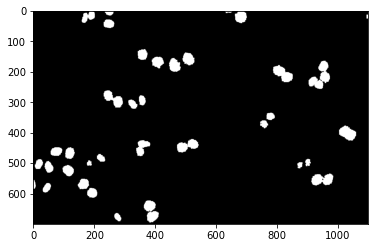

In [30]:
show(create_img(pts))

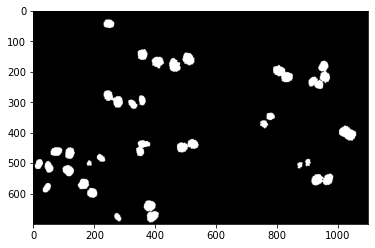

In [31]:
show(create_img(new))

In [32]:
def flush_border_cells(pts, img):
    to_check = []
    border_pts = {}
    border_img = np.zeros((NROWS, NCOLS))
    for pt in pts:
        if pt[0] == 0 or pt[1] == 0 or pt[0] == NROWS-1 or pt[1] == NCOLS-1:
            to_check.append(pt)
            border_pts[pt] = None
            border_img[pt[0], pt[1]] = MAX
    cnt = 0
    while cnt < 50000:
        if len(to_check) == 0:
            break
        if cnt == 49999:
            print(len(to_check))
        b_pt = to_check.pop(0)
        for i in range(-1, 2):
            for j in range(-1, 2):
                if (b_pt[0]+i, b_pt[1]+j) in pts and (b_pt[0]+i, b_pt[1]+j) not in border_pts:
                    to_check.append((b_pt[0]+i, b_pt[1]+j))
                    border_pts[(b_pt[0]+i, b_pt[1]+j)] = None
                    border_img[b_pt[0]+i, b_pt[1]+j] = MAX
        cnt += 1
    new = img - border_img
    return new.astype('uint16'), border_pts

In [33]:
img, pts = flush_border_cells(points(img2), img2)

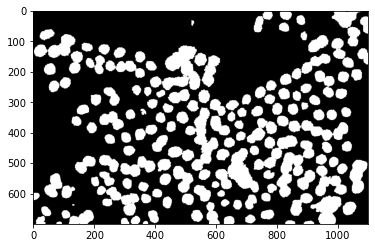

In [34]:
show(img2)

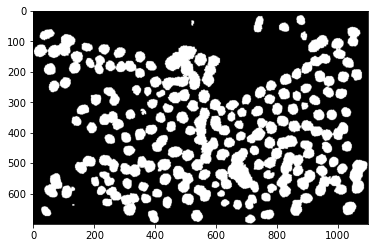

In [35]:
show(img)

## Cluster: to find centroids

In [36]:
pts = np.array([list(pt) for pt in flush_border(points(img3))])
cluster = DBSCAN(eps=1.5, min_samples=1).fit(pts)
print(cluster.labels_)
print(np.unique(cluster.labels_))

[ 0  0  0 ... 29 29 29]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]


In [37]:
def show_point_lables(pts, labels):
    pass

In [38]:
def get_centroids(img, method):
    pts = np.array([list(pt) for pt in flush_border(points(img))])
    cluster = method.fit(pts)
    extrema = {}
    pts_labels = {}
    for i, label in enumerate(cluster.labels_):
        if label == -1:
            continue
        pts_labels[tuple(pts[i])] = label
        if label not in extrema:
            extrema[label] = {'x1': pts[i][0], 'x2': pts[i][0],
                              'y1': pts[i][1], 'y2': pts[i][1]}
            continue
        if pts[i][0] < extrema[label]['x1']:
            extrema[label]['x1'] = pts[i][0]
        elif pts[i][0] > extrema[label]['x2']:
            extrema[label]['x2'] = pts[i][0]
        if pts[i][1] < extrema[label]['y1']:
            extrema[label]['y1'] = pts[i][1]
        elif pts[i][1] > extrema[label]['y2']:
            extrema[label]['y2'] = pts[i][1]
    centroids = {}
    for label in extrema.keys():
        ext = extrema[label]
        centroids[label] = (int((ext['x1'] + ext['x2']) / 2), 
                            int((ext['y1'] + ext['y2']) / 2))
    return centroids, pts_labels

In [39]:
# DBSCAN(eps=1.5, min_samples=1) is fast
# AffinityPropagation(damping=1.0, random_state=None) BRICKS PC

In [40]:
cs, pts_labels = get_centroids(img3, DBSCAN(eps=1.5, min_samples=1))

In [338]:
def colour_label_image(pts_labels, show=True):
    cmap = cm.get_cmap('hsv').copy()
    new_img = np.zeros((NROWS, NCOLS))
    cmap.set_bad(color='black')
    for (pt, label) in pts_labels.items():
        new_img[pt[0],pt[1]] = label
    norm_new = plt.Normalize(new_img.min(), new_img.max())
    for i in range(NROWS):
        for j in range(NCOLS):
            if (i,j) not in pts_labels:
                new_img[i,j] = np.nan
    rgba_img = cmap(norm_new(new_img))
    if show:
        plt.imshow(rgba_img)
        plt.show()
    return rgba_img

In [339]:
def plt_rgb_img_scatter(cs, pts_labels=None):
    rgb_img = colour_label_image(pts_labels, False)
    plt.imshow(rgb_img)
    if pts_labels != None:
        for (x, y) in cs.values():
            plt.scatter(y, x, c='white', marker='o')
    plt.show()

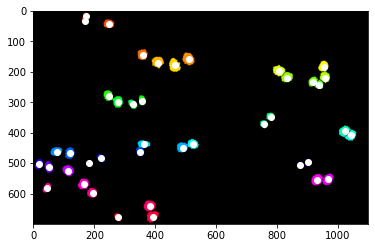

In [340]:
plt_rgb_img_scatter(cs, pts_labels)

## Area Based Centroids from Contours + Area + Cell Count

In [170]:
def check_coords(pt):
    if pt[0] < 0 or pt[0] > NROWS-1 or pt[1] < 0 or pt[1] > NCOLS-1:
        return False
    return True

In [317]:
def erode(pts):
    eroded1_pts = {}
    for (x,y) in pts:
        if (x,y-1) in pts and (x, y+1) in pts:
            eroded1_pts[(x,y)] = pts[(x,y)]
    eroded2_pts = {}
    for (x,y) in eroded1_pts:
        if (x-1,y) in eroded1_pts and (x+1, y) in eroded1_pts:
            eroded2_pts[(x,y)] = eroded1_pts[(x,y)]
    return eroded2_pts

In [329]:
def dilate(pts):
    dilated1_pts = pts.copy()
    for (x,y) in pts:
        if (x,y-1) not in pts and check_coords((x,y-1)):
            dilated1_pts[(x, y-1)] = pts[(x,y)]
        if (x, y+1) not in pts and check_coords((x,y+1)):
            dilated1_pts[(x, y+1)] = pts[(x,y)]
    dilated2_pts = dilated1_pts.copy()
    for (x,y) in dilated1_pts:
        if (x-1,y) not in dilated1_pts and check_coords((x-1,y)):
            dilated2_pts[(x-1, y)] = dilated1_pts[(x,y)]
        if (x+1, y) not in dilated1_pts and check_coords((x+1,y)):  
            dilated2_pts[(x+1, y)] = dilated1_pts[(x,y)]
    return dilated2_pts

In [324]:
def get_contours(pts):
    eroded2_pts = erode(pts)
    dilated2_pts = dilate(pts)
    
    sub = {}
    for pt, label in dilated2_pts.items():
    #for pt in pts:
        if pt not in pts:
        #if pt not in eroded2_pts:
            sub[pt] = label
    return sub

In [325]:
img_contours = get_contours(points(img3))

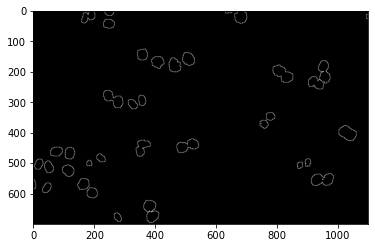

In [326]:
show(create_img(img_contours))

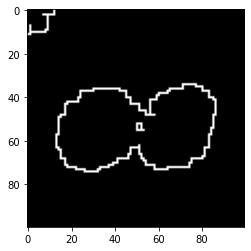

In [177]:
show(create_img(img_contours)[500:600,900:1000])

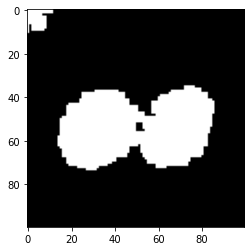

In [178]:
show(img3[500:600,900:1000])

In [182]:
flushed_img3 = 
distance = ndi.distance_transform_edt(img3)

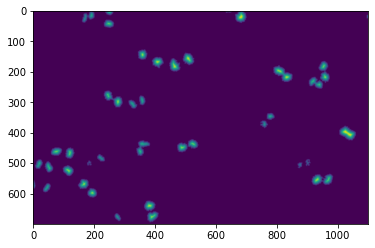

In [155]:
plt.imshow(distance)

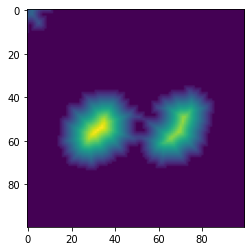

In [121]:
plt.imshow(distance[500:600,900:1000])

In [219]:
coords = peak_local_max(distance, footprint=np.ones((7,7)), labels = img3, min_distance=12)

In [225]:
coords = {tuple(c): i for i, c in enumerate(coords)}

In [226]:
len(coords)

45

In [227]:
coords

{(23, 682): 0,
 (398, 1026): 1,
 (408, 1041): 2,
 (158, 509): 3,
 (219, 833): 4,
 (184, 465): 5,
 (169, 408): 6,
 (639, 381): 7,
 (555, 932): 8,
 (200, 811): 9,
 (300, 279): 10,
 (219, 959): 11,
 (598, 195): 12,
 (526, 118): 13,
 (146, 359): 14,
 (569, 167): 15,
 (677, 389): 16,
 (450, 488): 17,
 (438, 526): 18,
 (185, 953): 19,
 (467, 121): 20,
 (463, 76): 21,
 (44, 248): 22,
 (276, 245): 23,
 (556, 969): 24,
 (244, 939): 25,
 (517, 54): 26,
 (463, 352): 27,
 (233, 918): 28,
 (437, 359): 29,
 (348, 778): 30,
 (502, 20): 31,
 (16, 192): 32,
 (294, 358): 33,
 (306, 326): 34,
 (580, 46): 35,
 (373, 760): 36,
 (677, 277): 37,
 (482, 220): 38,
 (31, 169): 39,
 (18, 172): 40,
 (505, 876): 41,
 (12, 253): 42,
 (499, 902): 43,
 (498, 185): 44}

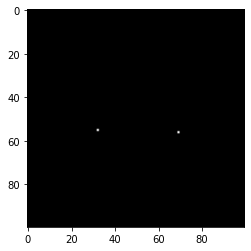

In [200]:
show(create_img(coords)[500:600,900:1000])

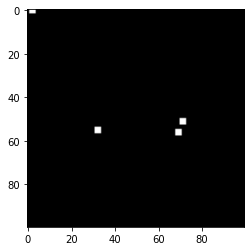

In [130]:
dil1 = dilate(coords)
show(create_img(dil1)[500:600,900:1000])

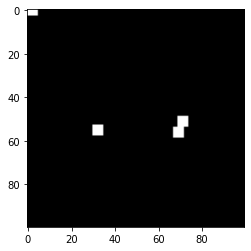

In [131]:
dil2 = dilate(dil1)
show(create_img(dil2)[500:600,900:1000])

In [407]:
def no_collision(pt, label, existing_pts):
    for (i,j) in [(0, -1), (0, 1), (-1, 0), (1, 0)]:
        point = (pt[0]+i,pt[1]+j)
        if point in existing_pts and label != existing_pts[point]:
                return False
    '''
    for i in range(-1, 2):
        for j in range(-1, 2):
            point = (pt[0]+i,pt[1]+j)
            if point in existing_pts and label != existing_pts[point]:
                return False
    '''
    return True

In [408]:
def rebuild(img):
    # could use flushed image? Depends on cell tracking
    pts = points(img)
    distance = ndi.distance_transform_edt(img)
    coords = peak_local_max(distance, footprint=np.ones((7,7)), labels = img, min_distance=12)
    coords = {tuple(c): i for i, c in enumerate(coords)}
    
    dilated2_pts = coords.copy()
    while 1:
        base = dilated2_pts.copy()
        dilated1_pts = base.copy()
        for pt, label in base.items():
            pt1 = (pt[0],pt[1]-1)
            if pt1 in dilated1_pts:
                pass
            elif no_collision(pt1, label, dilated1_pts) and pt1 in pts:
                dilated1_pts[pt1] = label
            
            pt2 = (pt[0], pt[1]+1)
            if pt2 in dilated1_pts:
                pass
            elif no_collision(pt2, label, dilated1_pts) and pt2 in pts:
                dilated1_pts[pt2] = label
       
        dilated2_pts = dilated1_pts.copy()
        for pt, label in dilated1_pts.items():
            pt1 = (pt[0]-1,pt[1])
            if pt1 in dilated2_pts:
                pass
            elif no_collision(pt1, label, dilated2_pts) and pt1 in pts:
                dilated2_pts[pt1] = label
            
            pt2 = (pt[0]+1, pt[1])
            if pt2 in dilated2_pts:
                pass
            elif no_collision(pt2, label, dilated2_pts) and pt2 in pts:
                dilated2_pts[pt2] = label
        if base == dilated2_pts:
            break
    colour_label_image(dilated2_pts)
    return dilated2_pts 

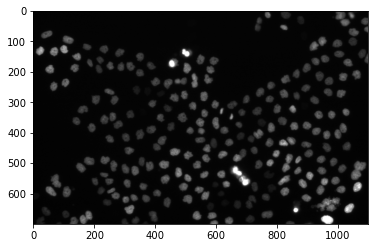

In [345]:
show(imgs[3][-1])

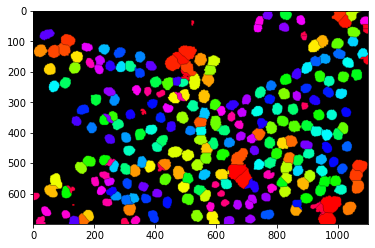

In [412]:
new_pts2 = rebuild(img2)

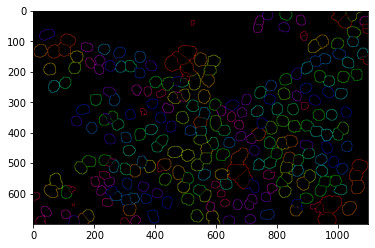

In [413]:
new_contours2 = get_contours(new_pts2)
_ = colour_label_image(new_contours2)

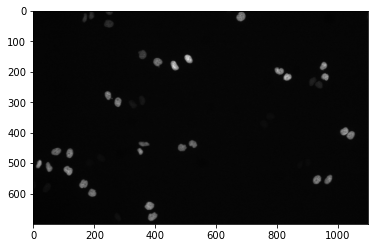

In [397]:
show(imgs[0][0])

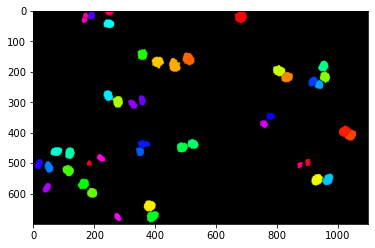

In [409]:
new_pts3 = rebuild(img3)

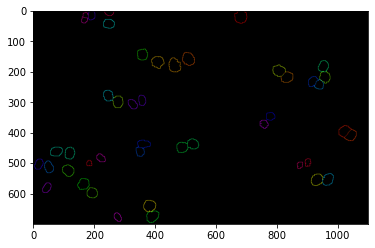

In [404]:
new_contours3 = get_contours(new_pts3)
_ = colour_label_image(new_contours3)

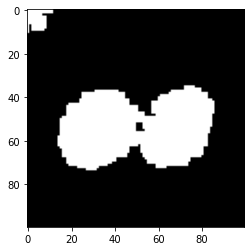

In [410]:
show(img3[500:600,900:1000])

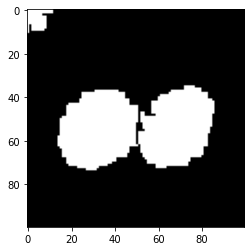

In [411]:
show(create_img(new_pts3)[500:600,900:1000])

In [393]:
def centres(pts):
    extrema = {}
    for (x,y), label in pts.items():
        if label not in extrema:
            extrema[label] = {'x1': x, 'x2': x, 'y1': y, 'y2': y}

In [ ]:
crtds = centres(new)

## Watershed Algo

In [65]:
from scipy import ndimage as ndi
from skimage.morphology import watershed
from skimage.feature import peak_local_max

In [66]:
distance = ndi.distance_transform_edt(img3)

In [67]:
coords = peak_local_max(distance, footprint=np.ones((3,3)), labels = img3)

In [73]:
mask = np.zeros(distance.shape, dtype = bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
ws_labels = watershed(-distance, markers, mask = img3)

C:\Users\moate\anaconda3\envs\COMP9517\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


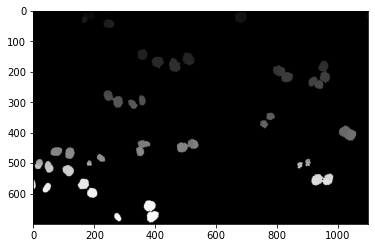

In [69]:
show(ws_labels)

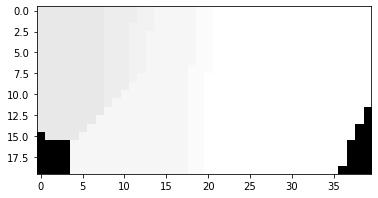

In [89]:
show(ws_labels[400:420,1020:1060])

In [90]:
ws_labels[400:420,1020:1060]

array([[50, 50, 50, 50, 50, 50, 50, 50, 51, 51, 51, 51, 52, 52, 53, 53,
        53, 53, 53, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55,
        55, 55, 55, 55, 55, 55, 55, 55],
       [50, 50, 50, 50, 50, 50, 50, 50, 51, 51, 51, 51, 52, 52, 53, 53,
        53, 53, 53, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55,
        55, 55, 55, 55, 55, 55, 55, 55],
       [50, 50, 50, 50, 50, 50, 50, 50, 51, 51, 51, 52, 52, 52, 53, 53,
        53, 53, 53, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55,
        55, 55, 55, 55, 55, 55, 55, 55],
       [50, 50, 50, 50, 50, 50, 50, 50, 51, 51, 51, 52, 52, 53, 53, 53,
        53, 53, 53, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55,
        55, 55, 55, 55, 55, 55, 55, 55],
       [50, 50, 50, 50, 50, 50, 50, 50, 51, 51, 51, 52, 52, 53, 53, 53,
        53, 53, 53, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55,
        55, 55, 55, 55, 55, 55, 55, 55],
       [50, 50, 50, 50, 50, 50, 50, 50, 51, 51, 51, 52, 52, 53, 53, 53,
   

## Compute local labels and contours for some consecutive images

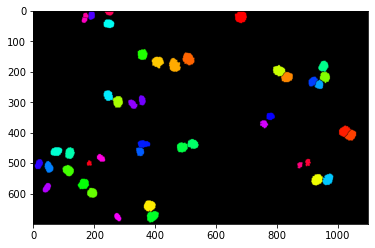

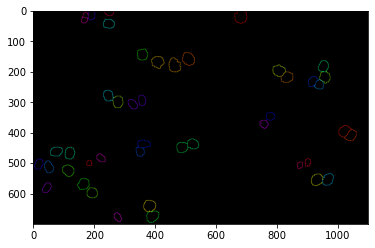

In [389]:
new_pts3 = rebuild(img3)
new_contours3 = get_contours(new_pts3)
_ = colour_label_image(new_contours3)